In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline
import hvplot.pandas
import montecarlo as mc
import seaborn as sns
import panel as pn
from panel.interact import interact

from iexfinance.stocks import get_historical_data
import iexfinance as iex


In [2]:
tickers_dict = {"index":["VOO"],
                "crypto":['BTC', 'ETH', 'XRP']}
years = 1
data_start_date = datetime.now() + timedelta(-365*years)

In [3]:
portfolio_hist_prices = mc.get_historic_data(ticker = tickers_dict["index"], 
                                             start_date = data_start_date)
#portfolio_hist_prices.head()

In [4]:
btc_daily_price = mc.get_crypto_daily_price(tickers_dict["crypto"],limit=data_start_date,allData=True)
#btc_daily_price.head()

In [5]:
portfolio_hist_prices = pd.concat([portfolio_hist_prices,btc_daily_price],axis=1,join="inner")
portfolio_hist_prices.dropna(inplace=True)
#portfolio_hist_prices.head()

In [6]:
portfolio_hist_prices = mc.normalize_dataframe(portfolio_hist_prices)
portfolio_daily_retn = portfolio_hist_prices.pct_change().copy()

#portfolio_daily_retn

In [7]:
def corr_plot(portfolio_daily_retn):
    correlated = portfolio_daily_retn.corr()
    #correlated
    #A failed attemp to use hvplot to create a heatmap. Worthy of more research.
    #correlated_plot = correlated.hvplot.heatmap(x = correlated.index.values, y = correlated.columns.values)
    #correlated_plot #didn't work. It would be cool to find another way.
    # Generate a mask for the upper triangle
    mask = np.zeros_like(correlated, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Set up the matplotlib figure
    correlated_plot, ax = plt.subplots(figsize=(6, 4))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(correlated, mask=mask, cmap="coolwarm", vmax=1, vmin =-1, center=0,
                square=True, linewidths=.5, annot=True
                #cbar_kws={"shrink": .5}
               )
    
    #correlated_plot = sns.heatmap(correlated, vmin=-1, vmax=1, annot=True,cmap="coolwarm") 
    plt.close()
    return pn.Pane(correlated_plot)

In [8]:
def sharp_rt_plot(portfolio_daily_retn):
    
    sharp_ratios = portfolio_daily_retn.mean()*np.sqrt(252)/portfolio_daily_retn.std()
    
    #with hvplot(): 
    #sr_plot = sharp_ratios.hvplot.bar()
    
    sr_plot = plt.figure();
    plt.bar(x = sharp_ratios.index, height=sharp_ratios)
    plt.axhline(sharp_ratios.mean(), color='r')
    #plt.ylim(sharp_ratios.min()*0.997,sharp_ratios.max()*1.002)
    plt.close()
    return sr_plot

In [9]:

monte_carlo_sim = mc.monte_carlo_sim(df=portfolio_hist_prices, trials=10, sim_days=252)

def plot_mont_carl(monte_carlo_sim):
    plot_title = f"title"
    monte_carlo_sim_plot = monte_carlo_sim.hvplot(title=plot_title,figsize=(18,10))
    return monte_carlo_sim_plot

In [10]:
def get_conf_interval(db,q=[0.05, 0.95]):
    confidence_interval = db.iloc[-1].quantile(q=q)
    return confidence_interval

In [11]:
def plot_conf(values=monte_carlo_sim.iloc[-1],conf=[0,0]):
    conifidence_plot = plt.figure();
    #plt.plot(values,kind='hist', density=True, bins=20)
    plt.hist(x = values,bins=20)
    plt.axvline(conf.iloc[0], color='r')
    plt.axvline(conf.iloc[1], color='r')
    plt.close()
    return pn.Pane(conifidence_plot)

# DASHBOARD TIME!!!

In [12]:
mc_sim = mc.monte_carlo_sim(portfolio_hist_prices,trials = 100)

In [13]:
risk_tabs = pn.Tabs(
    ("Correlation of portfolio",corr_plot(portfolio_daily_retn)),
    ("Sharp Ratios", sharp_rt_plot(portfolio_daily_retn))
)

In [14]:
montecarlo_tabs = pn.Tabs(
    ("monte Carlo Simulation",plot_mont_carl(mc_sim)),
    ("Confidence Intervals", plot_conf(mc_sim.iloc[-1],get_conf_interval(mc_sim)))
)

In [15]:
techl_analysis_tabs = pn.Tabs(
    ("TA1","in construction"),
    ("TA2", "in construction")
)

In [16]:
tabs = pn.Tabs(
    ("Risk",risk_tabs),
    ("Monte Carlo Simulation", montecarlo_tabs),
    ("Tecnical Analysis", techl_analysis_tabs),
    ("Report", "in construction")
)
  

Tabs
    [0] Tabs
        [0] Matplotlib(Figure)
        [1] Matplotlib(Figure, name='Sharp Ratios')
    [1] Tabs
        [0] HoloViews(NdOverlay, name='monte Carlo Simulation')
        [1] Matplotlib(Figure)
    [2] Tabs
        [0] Markdown(str, name='TA1')
        [1] Markdown(str, name='TA2')
    [3] Markdown(str, name='Report')
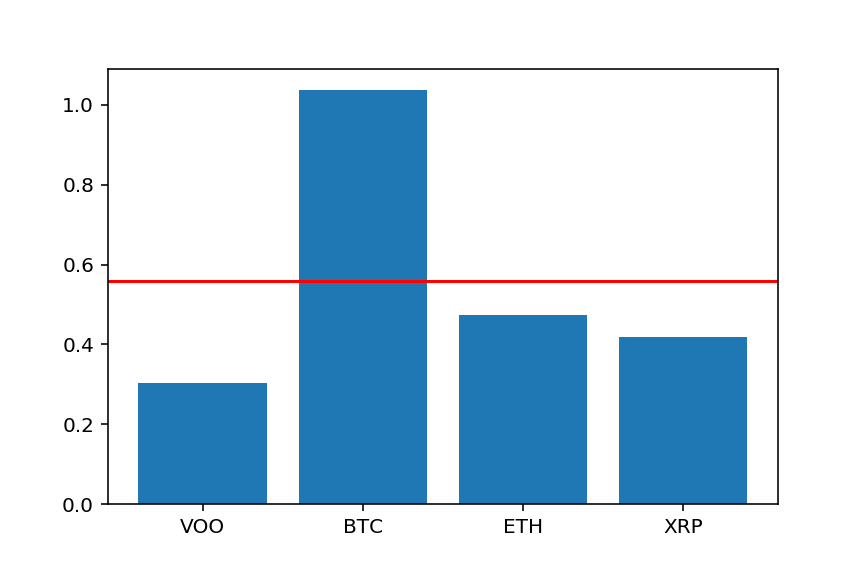
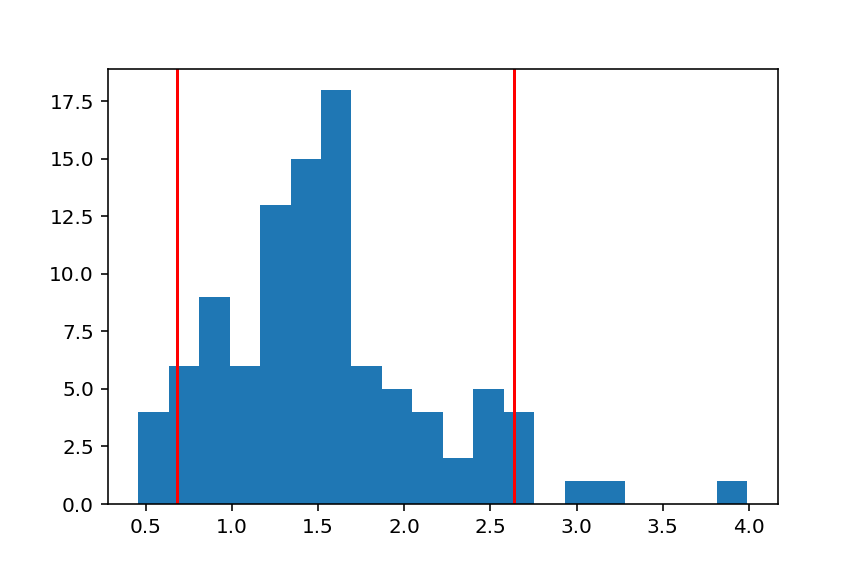
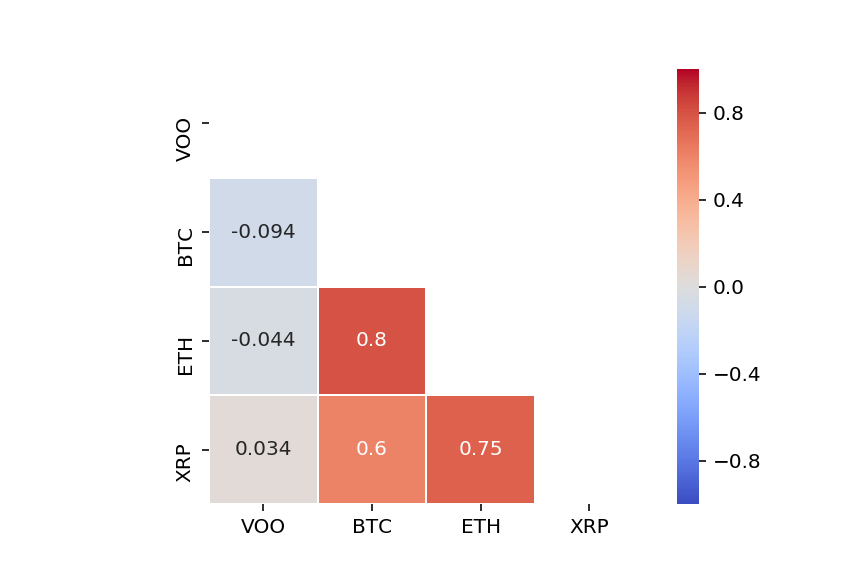

In [17]:
  
panel = tabs

panel